# Classify images from MNIST using LeNet

## Dataset

Download the [dataset](http://deeplearning.net/data/mnist/mnist.pkl.gz) to your workingspace

In [1]:
import cPickle, gzip

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, _ = cPickle.load(f)
f.close()

In [2]:
print train_set[0].shape, train_set[1].shape
print valid_set[0].shape, valid_set[1].shape

(50000, 784) (50000,)
(10000, 784) (10000,)


In [11]:
import numpy as np
train_x = np.reshape(train_set[0], (50000, 1, 28, 28)).astype(np.float32, copy=False)
train_y = np.array(train_set[1]).astype(np.int32, copy=False)
valid_x = np.reshape(valid_set[0], (10000, 1, 28, 28))

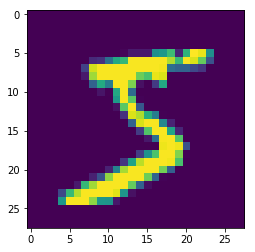

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_x[0][0])

## Create the CNN model

TODO: plot the net structure

In [5]:
from singa import net as ffnet
from singa.layer import Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Dense
from singa import optimizer, loss, metric
from singa import layer
layer.engine = 'singacpp'
net = ffnet.FeedForwardNet(loss.SoftmaxCrossEntropy(), metric.Accuracy())
net.add(Conv2D('conv1', 32, 3, 2, input_sample_shape=(1,28,28)))
net.add(Activation('relu1'))
net.add(Conv2D('conv2', 32, 3, 2))
net.add(Activation('relu2'))
net.add(MaxPooling2D('pool', 3, 2))
net.add(Flatten('flat'))
net.add(Dense('dense', 10))


conv1 (32, 14, 14)
relu1 (32, 14, 14)
conv2 (32, 7, 7)
relu2 (32, 7, 7)
pool (32, 4, 4)
flat (512,)
dense (10,)
conv1_weight (32, 9) 0.0764843672514
conv1_bias (32,) 0.0
conv2_weight (32, 288) 0.0803024768829
conv2_bias (32,) 0.0
dense_weight (512, 10) 0.0795410946012
dense_bias (10,) 0.0


## Initialize the parameters

* weight matrix - guassian distribution
* bias - 0

In [ ]:
for pname, pval in zip(net.param_names(), net.param_values()):
    if len(pval.shape) > 1:
        pval.gaussian(0, 0.1)
    else:
        pval.set_value(0)
    print pname, pval.shape, pval.l1()

## Set up the optimizer and tensors

In [15]:
from singa import tensor
from singa.proto import core_pb2
from singa import device
from singa import utils
cpu = device.get_default_device()

opt = optimizer.SGD(momentum=0.9, weight_decay=1e-4)
batch_size = 32
num_train_batch = train_x.shape[0] / batch_size

tx = tensor.Tensor((batch_size, 1, 28, 28))
ty = tensor.Tensor((batch_size,), cpu , core_pb2.kInt)

from tqdm import tnrange
idx = np.arange(train_x.shape[0], dtype=np.int32)

## Conduct SGD

1. process the training data multile time, each time is called on epoch; 
2. for each epoch, read the data as mini-batches in random order
3. for each mini-batch, do BP and update the parameters  

In [23]:
for epoch in range(2):
    np.random.shuffle(idx)
    loss, acc = 0.0, 0.0
    
    bar = tnrange(num_train_batch, desc='Epoch %d' % epoch)
    for b in bar:
        x = train_x[idx[b * batch_size: (b + 1) * batch_size]]
        y = train_y[idx[b * batch_size: (b + 1) * batch_size]]
        tx.copy_from_numpy(x)
        ty.copy_from_numpy(y)
        grads, (l, a) = net.train(tx, ty)
        loss += l
        acc += a
        for (s, p, g) in zip(net.param_names(), net.param_values(), grads):
            opt.apply_with_lr(epoch, 0.01, g, p, str(s), b)
        # update progress bar
        bar.set_postfix(train_loss=l, train_accuracy=a)
    print 'Epoch = %d, training loss = %f, training accuracy = %f' % (epoch, loss / num_train_batch, acc / num_train_batch)    



Epoch = 0, training loss = 0.049774, training accuracy = 0.984195

Epoch = 1, training loss = 0.045198, training accuracy = 0.985175


## Save model to disk

In [24]:
net.save('checkpoint')

## Load model from disk

In [ ]:
for pval in net.param_values():
    pval.set_value(0)
net.load('checkpoint')

## Do prediction

In [29]:
from PIL import Image
img = Image.open('static/digit.jpg').convert('L')
img = img.resize((28,28))
img = np.array(img, dtype=np.float32)/255
img = tensor.from_numpy(img)
img.reshape((1,1,28,28))
y=net.predict(img)

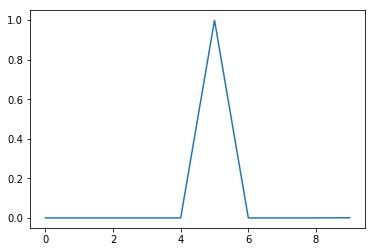

In [34]:
prob=tensor.to_numpy(y)[0]
plt.plot(range(10), prob)

## Debug

Print l1 norm or parameter and layer feature

1. parameter initialization
2. learning rate
3. weight decay


In [37]:
np.random.shuffle(idx)
ffnet.verbose=True
for b in range(5):
    print "\n\nEpoch %d" % b
    x = train_x[idx[b * batch_size: (b + 1) * batch_size]]
    y = train_y[idx[b * batch_size: (b + 1) * batch_size]]
    tx.copy_from_numpy(x)
    ty.copy_from_numpy(y)
    grads, (l, a) = net.train(tx, ty)
    for (s, p, g) in zip(net.param_names(), net.param_values(), grads):
        opt.apply_with_lr(epoch, 0.01, g, p, str(s), b)




Epoch 0
-->conv1: 0.166107
conv1-->relu1: 0.108610
relu1-->conv2: 0.903090
conv2-->relu2: 0.140909
relu2-->pool: 0.622060
pool-->flat: 0.622060
flat-->dense: 5.872416
-->dense: 0.000020
dense-->flat: 0.000020
flat-->pool: 0.000006
pool-->relu2: 0.000003
relu2-->conv2: 0.000007
conv2-->relu1: 0.000003
relu1-->conv1: 0.000020


Epoch 1
-->conv1: 0.172752
conv1-->relu1: 0.112391
relu1-->conv2: 0.927154
conv2-->relu2: 0.149621
relu2-->pool: 0.666872
pool-->flat: 0.666872
flat-->dense: 5.489178
-->dense: 0.000081
dense-->flat: 0.000081
flat-->pool: 0.000023
pool-->relu2: 0.000013
relu2-->conv2: 0.000034
conv2-->relu1: 0.000016
relu1-->conv1: 0.000103


Epoch 2
-->conv1: 0.170042
conv1-->relu1: 0.110705
relu1-->conv2: 0.921814
conv2-->relu2: 0.147750
relu2-->pool: 0.657527
pool-->flat: 0.657527
flat-->dense: 5.475877
-->dense: 0.000189
dense-->flat: 0.000189
flat-->pool: 0.000051
pool-->relu2: 0.000035
relu2-->conv2: 0.000088
conv2-->relu1: 0.000041
relu1-->conv1: 0.000258


Epoch 3
-->con

In [38]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [45]:
np.random.shuffle(idx)
ffnet.verbose=False

b=1
x = train_x[idx[b * batch_size: (b + 1) * batch_size]]    
tx.copy_from_numpy(x)

r = net.forward(False, tx, ['relu1', 'relu2'])


    

(32, 14, 14)


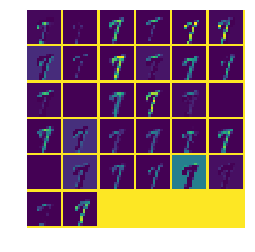

In [46]:
r1 = tensor.to_numpy(r['relu1'])[0]
vis_square(r1)

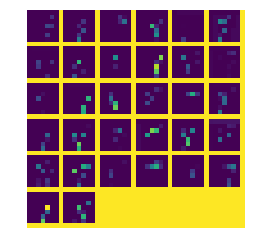

In [47]:
r2 = tensor.to_numpy(r['relu2'])[0]
vis_square(r2)